# LangChain Integration

For this part of the project we follow the tutorial of "LangChain" and adapt it for the stock market (see details in: [Graph Tutorial on LangChain Documentation](https://python.langchain.com/docs/tutorials/graph/)).

## 1. Dependencies

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from langchain_neo4j import Neo4jGraph, GraphCypherQAChain, Neo4jVector
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#Advanced LangGraph
from operator import add
from typing import Annotated, List, Literal, Optional
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_core.output_parsers import StrOutputParser
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema
from pydantic import BaseModel, Field
from neo4j.exceptions import CypherSyntaxError
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langchain.vectorstores import FAISS

## 2. Connections with Graph Database

In [186]:
uri = "bolt://localhost:7689"
username = "neo4j"          
password = "12345678"
graph = Neo4jGraph(uri, username, password)

In [187]:
nodes = graph.query("MATCH (n) RETURN n LIMIT 2")
for node in nodes:
    print(node)

{'n': {'symbol': 'AAPL', 'betweennessCentrality': 0.0, 'name': 'Apple Inc.', 'eigenvectorCentrality': 2.0812589256979136e-08, 'degreeCentrality': 3.0, 'sector': 'Information Technology'}}
{'n': {'symbol': 'ABBV', 'betweennessCentrality': 0.0, 'name': 'AbbVie', 'eigenvectorCentrality': 1.9054538849600147e-170, 'degreeCentrality': 0.0, 'sector': 'Health Care'}}


In [188]:
relationships = graph.query("MATCH (a)-[r]->(b) RETURN a, r, b LIMIT 2")
for relationship in relationships:
    print(relationship)

{'a': {'symbol': 'AAPL', 'betweennessCentrality': 0.0, 'name': 'Apple Inc.', 'eigenvectorCentrality': 2.0812589256979136e-08, 'degreeCentrality': 3.0, 'sector': 'Information Technology'}, 'r': ({'symbol': 'AAPL', 'betweennessCentrality': 0.0, 'name': 'Apple Inc.', 'eigenvectorCentrality': 2.0812589256979136e-08, 'degreeCentrality': 3.0, 'sector': 'Information Technology'}, 'BELONGS_TO', {'name': 'Information Technology'}), 'b': {'name': 'Information Technology'}}
{'a': {'symbol': 'AAPL', 'betweennessCentrality': 0.0, 'name': 'Apple Inc.', 'eigenvectorCentrality': 2.0812589256979136e-08, 'degreeCentrality': 3.0, 'sector': 'Information Technology'}, 'r': ({'symbol': 'AAPL', 'betweennessCentrality': 0.0, 'name': 'Apple Inc.', 'eigenvectorCentrality': 2.0812589256979136e-08, 'degreeCentrality': 3.0, 'sector': 'Information Technology'}, 'CORRELATED', {'symbol': 'AMZN', 'betweennessCentrality': 2.0, 'name': 'Amazon', 'eigenvectorCentrality': 2.985062353989397e-08, 'degreeCentrality': 5.0, 's

## 3. Integration with GraphCypherQAChain

In [189]:
graph.refresh_schema()
print(graph.schema)

Node properties:
Stock {symbol: STRING, name: STRING, sector: STRING, eigenvectorCentrality: FLOAT, betweennessCentrality: FLOAT, degreeCentrality: FLOAT, louvainCommunityId: INTEGER}
Sector {name: STRING}
Relationship properties:
CORRELATED {correlation: FLOAT}
The relationships:
(:Stock)-[:BELONGS_TO]->(:Sector)
(:Stock)-[:CORRELATED]->(:Stock)


In [190]:
enhanced_graph=Neo4jGraph(uri, username, password,enhanced_schema=True)
print(enhanced_graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: 'MATCH (n:`Stock`)\nWITH collect(distinct substring(toString(n.`symbol`), 0, 50)) AS `symbol_values`,\n     co

Node properties:
- **Stock**
  - `symbol`: STRING Example: "AAPL"
  - `name`: STRING Example: "Apple Inc."
  - `sector`: STRING Example: "Information Technology"
  - `eigenvectorCentrality`: FLOAT Min: 1.9054538849600147E-170, Max: 0.28373309268337865
  - `betweennessCentrality`: FLOAT Min: 0.0, Max: 111.3809523809524
  - `degreeCentrality`: FLOAT Min: 0.0, Max: 17.0
  - `louvainCommunityId`: INTEGER Min: 9, Max: 12
- **Sector**
  - `name`: STRING Example: "Information Technology"
Relationship properties:
- **CORRELATED**
  - `correlation`: FLOAT Min: 0.6009239619998398, Max: 0.8585241254499043
The relationships:
(:Stock)-[:BELONGS_TO]->(:Sector)
(:Stock)-[:CORRELATED]->(:Stock)


In [191]:
load_dotenv()
openai_api_key=os.getenv("OPENAI_API_KEY")
llm=ChatOpenAI(model="gpt-4o", temperature=0)
chain=GraphCypherQAChain.from_llm(
    graph=enhanced_graph, llm=llm, verbose=True, allow_dangerous_requests=True
)

In [192]:
response=chain.invoke({"query":"What are the top 10 stocks by eigenvector centrality?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s:Stock)
RETURN s.symbol, s.name, s.eigenvectorCentrality
ORDER BY s.eigenvectorCentrality DESC
LIMIT 10

Full Context:
[{'s.symbol': 'JPM', 's.name': 'JPMorgan Chase', 's.eigenvectorCentrality': 0.28373309268337865}, {'s.symbol': 'MET', 's.name': 'MetLife', 's.eigenvectorCentrality': 0.28275347463734357}, {'s.symbol': 'BK', 's.name': 'BNY Mellon', 's.eigenvectorCentrality': 0.27668837004417635}, {'s.symbol': 'MS', 's.name': 'Morgan Stanley', 's.eigenvectorCentrality': 0.27668837004417635}, {'s.symbol': 'BAC', 's.name': 'Bank of America', 's.eigenvectorCentrality': 0.27668837004417635}, {'s.symbol': 'BRK-B', 's.name': 'Berkshire Hathaway (Class B)', 's.eigenvectorCentrality': 0.2764113801812669}, {'s.symbol': 'USB', 's.name': 'U.S. Bancorp', 's.eigenvectorCentrality': 0.2671514470823249}, {'s.symbol': 'WFC', 's.name': 'Wells Fargo', 's.eigenvectorCentrality': 0.2671514470823249}, {'s.symbol': 'GS', 's.name': '

{'query': 'What are the top 10 stocks by eigenvector centrality?',
 'result': 'The top 10 stocks by eigenvector centrality are JPMorgan Chase, MetLife, BNY Mellon, Morgan Stanley, Bank of America, Berkshire Hathaway (Class B), U.S. Bancorp, Wells Fargo, Goldman Sachs, and American Express.'}

## 4. Advanced Implementation with LangGraph

Trying with LangGraph to enhance the workflow.

In [193]:
class InputState(TypedDict):
    question: str


class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]


class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

In [194]:
guardrails_system="""
As an intelligent assistant, your primary objective is to decide whether a given question is related to stocks or finance.
If the question is related to stocks, stock market data, or financial analysis, output "stock". Otherwise, output "end".
To make this decision, assess the content of the question and determine if it refers to stocks, stock market, financial terms, or stock-related data.
Provide only the specified output:"stock" or "end".
"""

guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system,
        ),
        (
            "human",
            ("{question}"),
        ),
    ]
)

class GuardrailsOutput(BaseModel):
    decision:Literal["stock","end"]=Field(
        description="Decision on whether the question is related to stocks or finance"
    )

guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

def guardrails(state: InputState) -> OverallState:
    question = state.get("question")
    if not question:
        raise ValueError("The 'question' key is missing or has a None value in InputState.")
    
    print(f"Invoking guardrails_chain with question: {question}")
    guardrails_output = guardrails_chain.invoke({"question": question})
    print(f"Guardrails output: {guardrails_output}")
    
    database_records = None
    if guardrails_output.decision == "end":
        database_records = "This question is not related to stocks or finance. Therefore, I cannot answer it."
    
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"],
    }

**few-shot prompting**

The idea is guide the LLM in query generation.

In [195]:
examples = [
    {
        "question": "How many stocks belong to the Information Technology sector?",
        "query": "MATCH (s:Stock)-[:BELONGS_TO]->(:Sector {name: 'Information Technology'}) RETURN count(DISTINCT s)",
    },
    {
        "question": "Which stocks have a correlation with AAPL?",
        "query": "MATCH (a:Stock {symbol: 'AAPL'})-[:CORRELATED]->(b:Stock) RETURN b.symbol",
    },
    {
        "question": "How many stocks belong to the Health Care sector?",
        "query": "MATCH (s:Stock)-[:BELONGS_TO]->(:Sector {name: 'Health Care'}) RETURN count(s)",
    },
    {
        "question": "List the sectors that AAPL belongs to.",
        "query": "MATCH (s:Stock {symbol: 'AAPL'})-[:BELONGS_TO]->(sector:Sector) RETURN sector.name",
    },
    {
        "question": "Which stocks are highly correlated with Amazon?",
        "query": "MATCH (a:Stock {symbol: 'AMZN'})-[:CORRELATED]->(b:Stock) RETURN b.symbol ORDER BY r.correlation DESC LIMIT 10",
    },
    {
        "question": "Which stocks have an eigenvector centrality higher than 0.1?",
        "query": "MATCH (s:Stock) WHERE s.eigenvectorCentrality > 0.1 RETURN s.symbol, s.eigenvectorCentrality",
    },
    {
        "question": "Find the sector with the most stocks.",
        "query": "MATCH (s:Stock)-[:BELONGS_TO]->(sector:Sector) RETURN sector.name, COUNT(s) AS num_stocks ORDER BY num_stocks DESC LIMIT 1",
    },
    {
        "question": "Which stocks have a high degree centrality?",
        "query": "MATCH (s:Stock) WHERE s.degreeCentrality > 10 RETURN s.symbol, s.degreeCentrality ORDER BY s.degreeCentrality DESC LIMIT 10",
    },
]

In [196]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples=examples,
    embeddings=OpenAIEmbeddings(),
    vectorstore_cls=FAISS,
    k=2
)

# Build the CypherQAChain with the example selector
chain = GraphCypherQAChain.from_llm(
    graph=graph,
    llm=llm,
    example_selector=example_selector,
    verbose=True,
    allow_dangerous_requests=True
)

# Test query
response = chain.invoke({"query": "What are the top 10 stocks by eigenvector centrality?"})
print(response)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (s:Stock)
RETURN s.symbol, s.name, s.eigenvectorCentrality
ORDER BY s.eigenvectorCentrality DESC
LIMIT 10

Full Context:
[{'s.symbol': 'JPM', 's.name': 'JPMorgan Chase', 's.eigenvectorCentrality': 0.28373309268337865}, {'s.symbol': 'MET', 's.name': 'MetLife', 's.eigenvectorCentrality': 0.28275347463734357}, {'s.symbol': 'BK', 's.name': 'BNY Mellon', 's.eigenvectorCentrality': 0.27668837004417635}, {'s.symbol': 'MS', 's.name': 'Morgan Stanley', 's.eigenvectorCentrality': 0.27668837004417635}, {'s.symbol': 'BAC', 's.name': 'Bank of America', 's.eigenvectorCentrality': 0.27668837004417635}, {'s.symbol': 'BRK-B', 's.name': 'Berkshire Hathaway (Class B)', 's.eigenvectorCentrality': 0.2764113801812669}, {'s.symbol': 'USB', 's.name': 'U.S. Bancorp', 's.eigenvectorCentrality': 0.2671514470823249}, {'s.symbol': 'WFC', 's.name': 'Wells Fargo', 's.eigenvectorCentrality': 0.2671514470823249}, {'s.symbol': 'GS', 's.name': '

In [197]:
text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information
{schema}

Below are a number of examples of questions and their corresponding Cypher queries.

{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema,
        }
    )
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

In [198]:
validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Stock) does not exist, did you mean (:Sector)?
* Property eigenvectorCentrality does not exist for label Stock, did you mean marketCap?
* Relationship CORRELATED does not exist, did you mean BELONGS_TO?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!
"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

In [199]:
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in enhanced_graph.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

In [200]:
def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statement and maps any property values to the database.
    """
    errors=[]
    mapping_errors=[]
    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
        
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    
    if llm_output.errors:
        errors.extend(llm_output.errors)
        
    if llm_output.filters:
        for filter in llm_output.filters:
            if not any(
                prop["property"] == filter.property_key and prop["type"] =="STRING"
                for prop in enhanced_graph.structured_schema["node_props"][filter.node_label]
             ):
                continue
            
            mapping= enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n. `{filter.property_key}`)= toLower($value) RETURN 'yes' LIMIT 1",
                {"value":filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

In [201]:
correct_cypher_prompt=ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer."
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """
                Check for invalid syntax or semantics and return a corrected Cypher statement.
                Scheme:
                {schema}
                Note: Do not include any explanations or apologies in your responses.
                Do not wrap the response in any backticks or anything else.
                Respond with a Cypher statement only!
                
                Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
                The question is:
                {question}
                The cypher statement is:
                {cypher}
                The errors are:
                {errors}
                
                Corrected Cypher statement:
                """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

In [202]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """

    records = enhanced_graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

In [203]:
generate_final_prompt=ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for a stock market database.",
        ),
        (
            "human",
            (
                """
                Use the following results retrieved from a stock market database to provide a succinct,
                definitive answer to the user's question.
                
                Respond as if you are answering the question directly.
                Results: {results}
                Question:{question}
                """
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:

    """"
    Generate the final answer based on database results and the user's question.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

In [204]:
def guardrails_condition(state: OverallState) -> Literal["generate_cypher", "generate_final_answer"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "stock":
        return "generate_cypher"

def validate_cypher_condition(
    state:OverallState,
) -> Literal ["generate_final_answer","correct_cypher","execute_cypher"]:
    if state.get("next_action") =="end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

In [205]:
langgraph=StateGraph(OverallState,input=InputState,output=OutputState)

langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START,"guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("generate_cypher","validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher","generate_final_answer")
langgraph.add_edge("correct_cypher","validate_cypher")
langgraph.add_edge("generate_final_answer",END)

langgraph = langgraph.compile()

Generating single mermaid chart


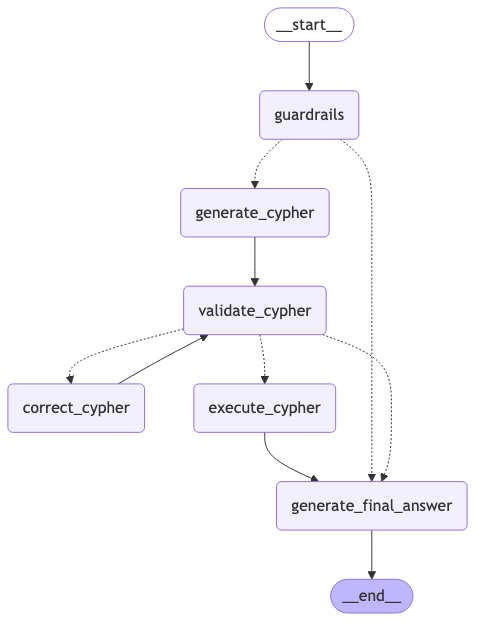

In [206]:
mermaid_code = langgraph.get_graph().draw_mermaid()
with open("../Image/langgraph.mmd", "w") as f:
    f.write(mermaid_code)

# Generate PNG using Mermaid CLI
import os
os.makedirs("../Image", exist_ok=True)
os.system("mmdc -i ../Image/langgraph.mmd -o ../Image/langgraph.png")

# Display the PNG
display(Image("../Image/langgraph.png"))

In [207]:
langgraph.invoke({"question": "How many stocks belong to the Information Technology sector?"})

Invoking guardrails_chain with question: How many stocks belong to the Information Technology sector?
Guardrails output: decision='stock'


{'answer': 'There are 18 stocks that belong to the Information Technology sector.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (s:Stock)-[:BELONGS_TO]->(:Sector {name: 'Information Technology'}) RETURN count(DISTINCT s)"}

In [208]:
langgraph.invoke({"question": "Which stocks have a correlation with AAPL?"})

Invoking guardrails_chain with question: Which stocks have a correlation with AAPL?
Guardrails output: decision='stock'


{'answer': 'The stocks that have a correlation with AAPL are AMZN, GOOGL, and MSFT.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (a:Stock {symbol: 'AAPL'})-[:CORRELATED]->(b:Stock) RETURN b.symbol"}